## Strategy:
- **Pairs Trading** using Bollinger Bands

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download historical data for Ford and General Motors
tickers = ["V", "MA"]
data = yf.download(tickers, start="2020-01-01", end="2025-07-01")

if data is None or data.empty:
    raise ValueError("Data could not be downloaded.")

/tmp/ipykernel_12663/1760103665.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-07-01")
[*********************100%***********************]  2 of 2 completed


In [3]:
print(f"Strategy data for {tickers[0]}/{tickers[1]} (last 10 days with signals):")
print(data.tail(10))

Strategy data for V/MA (last 10 days with signals):
Price            Close                    High                     Low  \
Ticker              MA           V          MA           V          MA   
Date                                                                     
2025-06-16  567.901550  354.855621  574.223014  359.587286  561.879730   
2025-06-17  568.680542  357.211456  570.518022  358.968375  563.237894   
2025-06-18  538.002014  339.782135  570.308337  357.850349  533.438182   
2025-06-20  532.249817  337.975311  537.612617  339.402792  526.617484   
2025-06-23  541.617126  343.146210  542.396102  343.695231  526.857130   
2025-06-24  556.776672  351.012360  563.357734  353.937206  551.743444   
2025-06-25  548.957214  344.653564  557.725318  350.672972  547.878657   
2025-06-26  545.072449  345.422211  548.168235  346.300670  541.337512   
2025-06-27  549.576416  347.997650  555.947800  351.391702  544.812842   
2025-06-30  561.180664  354.426361  561.869734  354.985375  

In [4]:
# Create a DataFrame for the strategy and make a column for the ratio
df = pd.DataFrame(index=data.index)
df["Ratio"] = data["Close"][tickers[0]] / data["Close"][tickers[1]]

In [5]:
# Set window size and number of standard deviations for Bollinger Bands calculation
window = 90
std_dev = 2.0

In [6]:
# Calculate Bollinger Bands for the ratio
df["SMA"] = df["Ratio"].rolling(window=window).mean()
df["STD"] = df["Ratio"].rolling(window=window).std()
df["Upper_Band"] = df["SMA"] + (df["STD"] * std_dev)
df["Lower_Band"] = df["SMA"] - (df["STD"] * std_dev)

In [7]:
# Generate entry signals
df["Signal"] = 0
df.loc[df["Ratio"] < df["Lower_Band"], "Signal"] = 1
df.loc[df["Ratio"] > df["Upper_Band"], "Signal"] = -1
df["Signal"] = df["Signal"].diff().fillna(0).clip(-1, 1)

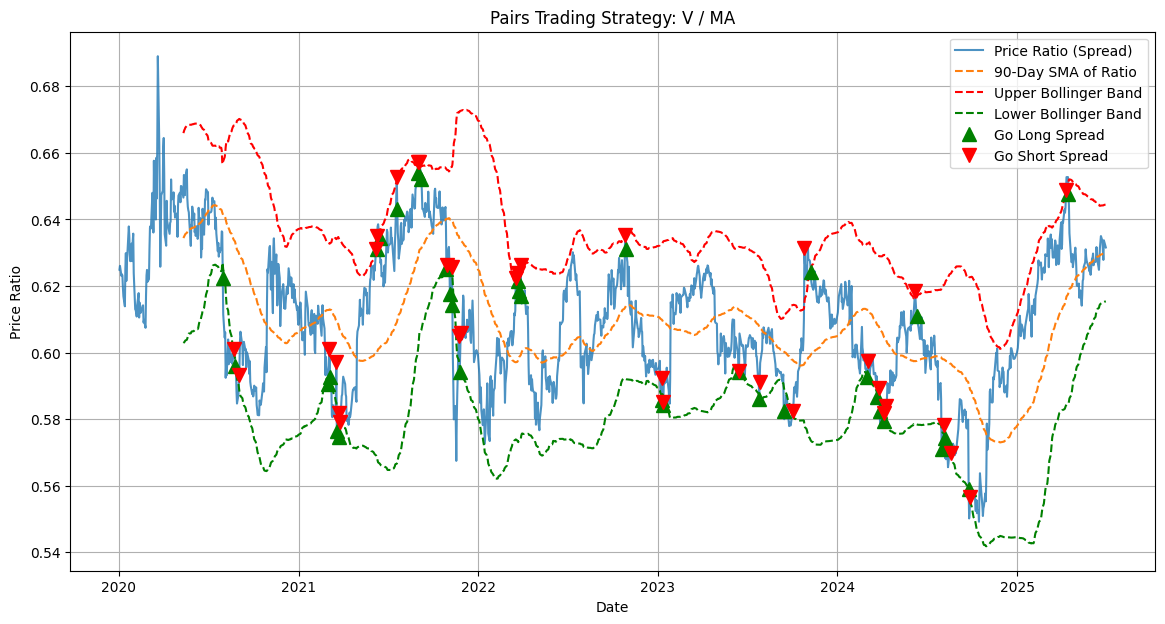

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df["Ratio"], label="Price Ratio (Spread)", alpha=0.8)
plt.plot(df["SMA"], label=f"{window}-Day SMA of Ratio", linestyle="--")
plt.plot(df["Upper_Band"], label="Upper Bollinger Band", linestyle="--", color="red")
plt.plot(df["Lower_Band"], label="Lower Bollinger Band", linestyle="--", color="green")

plt.plot(
    df[df["Signal"] == 1].index,
    df["Ratio"][df["Signal"] == 1],
    "^",
    markersize=10,
    color="g",
    lw=0,
    label="Go Long Spread",
)
plt.plot(
    df[df["Signal"] == -1].index,
    df["Ratio"][df["Signal"] == -1],
    "v",
    markersize=10,
    color="r",
    lw=0,
    label="Go Short Spread",
)

plt.title(f"Pairs Trading Strategy: {tickers[0]} / {tickers[1]}")
plt.xlabel("Date")
plt.ylabel("Price Ratio")
plt.legend()
plt.grid(True)

plt.show()

### Backtesting

In [9]:
def backtest_strategy(
    strategy_df, price_data, ticker1, ticker2, initial_capital=100_000
):
    """
    Performs a simple backtest of the pairs trading strategy.
    """
    capital = initial_capital
    position = 0
    portfolio = pd.DataFrame(index=strategy_df.index)
    portfolio["holdings"] = 0.0
    portfolio["cash"] = float(initial_capital)

    # Use a temporary position column to track state (0=flat, 1=long, -1=short)
    strategy_df["position"] = 0

    for i in range(len(strategy_df)):
        signal = strategy_df["Signal"].iloc[i]
        ratio = strategy_df["Ratio"].iloc[i]
        sma = strategy_df["SMA"].iloc[i]

        # Entry logic
        if position == 0:
            if signal == 1:  # Go Long
                position = 1
            elif signal == -1:  # Go Short
                position = -1
        # Exit logic
        elif position == 1 and ratio > sma:  # Exit long
            position = 0
        elif position == -1 and ratio < sma:  # Exit short
            position = 0

        strategy_df.loc[strategy_df.index[i], "position"] = position

    # Forward fill the position to calculate returns
    strategy_df["position"] = (
        strategy_df["position"].replace(0, np.nan).ffill().fillna(0)
    )

    # Calculate strategy returns
    daily_returns_t1 = price_data["Close"][ticker1].pct_change()
    daily_returns_t2 = price_data["Close"][ticker2].pct_change()
    strategy_df["strategy_returns"] = (strategy_df["position"] * daily_returns_t1) - (
        strategy_df["position"] * daily_returns_t2
    )

    # Calculate cumulative returns
    portfolio["returns"] = strategy_df["strategy_returns"]
    portfolio["equity_curve"] = (1 + portfolio["returns"]).cumprod() * initial_capital

    # --- Performance Metrics ---
    total_return = (portfolio["equity_curve"].iloc[-1] / initial_capital) - 1
    # Assuming 252 trading days in a year
    sharpe_ratio = (
        np.sqrt(252) * portfolio["returns"].mean() / portfolio["returns"].std()
    )

    print("--- Backtest Results ---")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${portfolio['equity_curve'].iloc[-1]:,.2f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print("------------------------")

    plt.figure(figsize=(14, 7))
    plt.plot(portfolio["equity_curve"], label="Portfolio Value")
    plt.title(f"Equity Curve for {ticker1}/{ticker2} Pairs Trading")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)

    plt.show()

--- Backtest Results ---
Initial Capital: $100,000.00
Final Portfolio Value: $119,812.93
Total Return: 19.81%
Sharpe Ratio: 0.35
------------------------


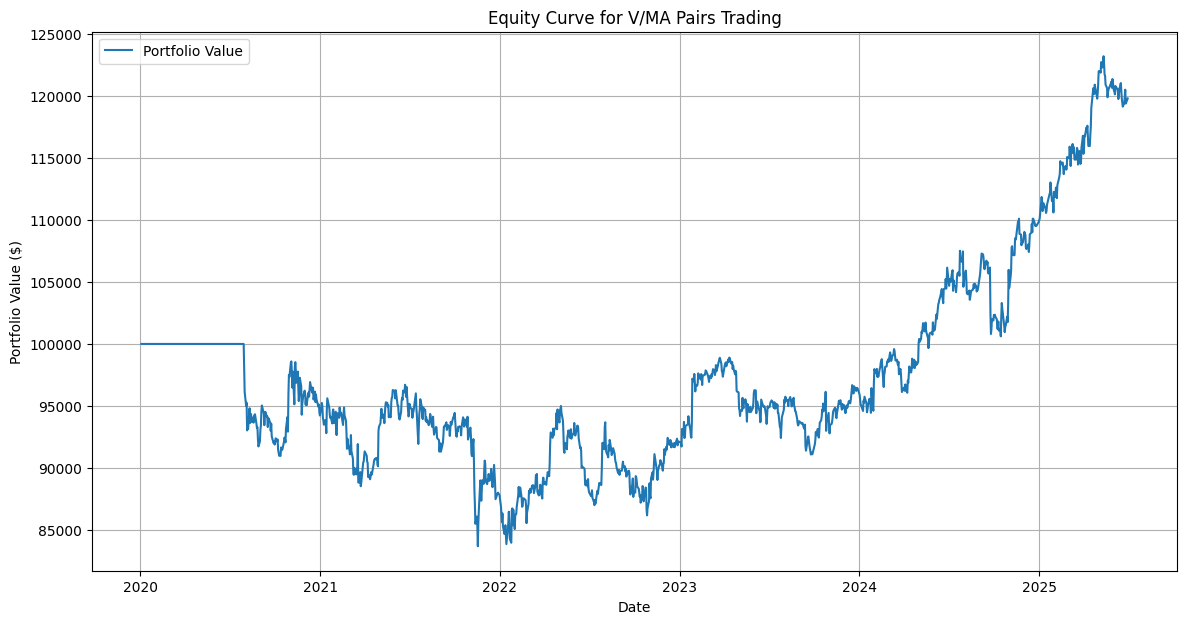

In [10]:
backtest_strategy(df, data, tickers[0], tickers[1])